In [82]:
import data2D as data_import
import os
import matplotlib.pyplot as plt
import numpy as np

D = 1e-8
N = 16

plt.rcParams.update({'font.size': 20})
plt.rc('figure', figsize=(20, 10))


In [83]:
# 3.2 pico seconds for particle to travel L
def exec(dt=0.1, dt2=0.1, tf=1e12, vx=5e3, vy=5e4, r=0):

    command = f"java -cp target/SimulacionTemporal-1.0-SNAPSHOT.jar \
                -Ddt={dt} -Ddt2={dt2} -Dtf={tf} \
                -Dvx={vx} -Dvy={vy} -Dr={r} \
                ElectricFieldSystem"
    proc = os.popen(command)
    print(proc.readlines())
    proc.close()
    data = data_import.Data("ElectricField.txt")
    return data


['Particle escaped!\n']
0.0 0.0
0.004724152037646168 18.295649922482927
0.03775912361555466 54.88695813136974
0.14155415745373157 91.47825273115025
0.36328295985579245 128.0693956454617
0.7501201973358345 164.66005528677945
1.3492428067670734 201.24962913290722
2.2078322317348946 237.83716626740218
3.3730778500817147 274.4212898494582
4.892181858175693 311.000119460837
6.812365878409047 347.5711932541434
9.180879558018798 384.1313898013966
12.045011429745065 420.67684951074716
15.452102308356297 457.2028954443149
19.44956150197222 493.70395333127976
24.084886123741736 530.1734705254896
29.405683798166017 566.6038336090734
35.459699067631206 602.9862842891496
42.2948438190211 639.3108331748359
49.95923206817987 675.566170956646
58.501219462128205 711.7395764369096
67.96944788603949 747.8168207797785
78.41289559491275 783.7820672598478
89.88093332962686 819.6177656892933
102.42338692480153 855.3045405917209
116.09060697300183 890.8210720663874
130.93354617795447 926.1439681457617
147.003

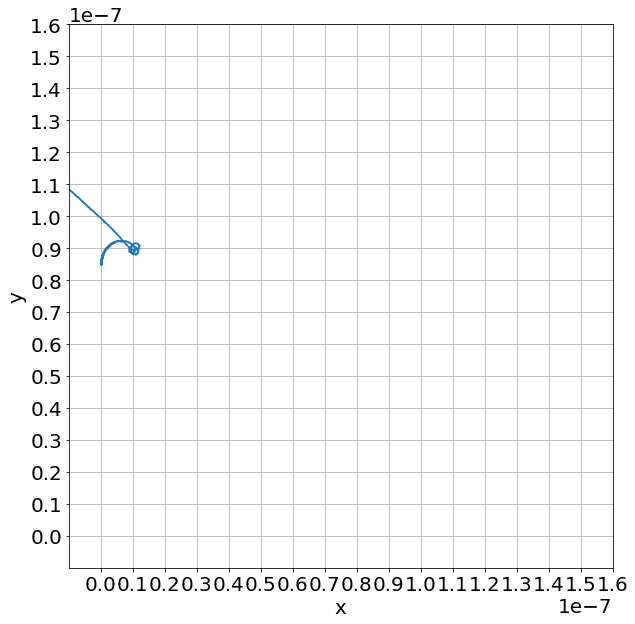

In [84]:
X = []
Y = []
ticks = np.arange(0, (N+1)*D, D)
data = exec(vx=0, vy=0, r=0)
for t, x, y, vx, vy in data:
    X.append(x)
    Y.append(y)

plt.figure("Trajectory")
plt.plot(X, Y, "o-", markersize=1)
plt.xticks(ticks)
plt.yticks(ticks)
plt.ylim(-D, N*D)
plt.xlim(-D, N*D)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.grid()

plt.show()